In [2]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from itertools import product
from typing import List
import pandas as pd
import numpy as np
import numba as nb
import imageio
import sys
import os
import shutil

randomSeed = 10

if "ipykernel_launcher.py" in sys.argv[0]:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'

if os.path.exists("/opt/conda/bin/ffmpeg"):
    plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"
else:
    plt.rcParams['animation.ffmpeg_path'] = "D:/Programs/ffmpeg/bin/ffmpeg.exe"

colors = ["#5C49AC", "#1F9BCE", "#00B5CA", "#BED45F", "#F9E03B"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

from main import *

SAVE_PATH = r"E:\MS_ExperimentData\general"
MP4_PATH = r"E:\MS_ExperimentData\mp4"

In [27]:
class Solvable2DWithRepulsion(Swarmalators2D):
    def __init__(self, agentsNum: int, dt: float, 
                 K: float, J: float, P: float,
                 randomSeed: int = 100, tqdm: bool = False, savePath: str = None, shotsnaps: int = 5, overWrite: bool = False) -> None:
        super().__init__(agentsNum, dt, K, randomSeed, tqdm, savePath, shotsnaps, overWrite)
        self.positionX = np.random.random((agentsNum, 2)) * 2 * np.pi
        self.J = J
        self.P = P
        self.one = np.ones((agentsNum, agentsNum))
        self.randomSeed = randomSeed

    def update_temp(self):
        self.temp["deltaTheta"] = self.deltaTheta
        self.temp["deltaX"] = self.deltaX

    def cotDeltaX(self, deltaX: np.ndarray) -> np.ndarray:
        """Cotangent of spatial difference: cot(x_j - x_i)"""
        return 1 / (np.tan(deltaX + (deltaX == 0)))

    @property
    def omega(self) -> np.ndarray:
        """Natural frequency: 0"""
        return 0

    @property
    def velocity(self) -> np.ndarray:
        """Self propulsion velocity: 0"""
        return 0

    @property 
    def Fatt(self) -> np.ndarray:
        """
        Effect of phase similarity on spatial attraction: J * cos(theta_j - theta_i) + 1
        """
        return self.J * np.cos(self.temp["deltaTheta"])
    
    @property
    def Frep(self) -> np.ndarray:
        """Effect of phase similarity on spatial repulsion: 1"""
        return self.one
    
    @property
    def Iatt(self) -> np.ndarray:
        """Spatial attraction: sin(x_j - x_i)"""
        return np.sin(3 * self.temp["deltaX"])

    @property
    def Irep(self) -> np.ndarray:
        """Spatial repulsion: P * sin((x_j - x_i) / 2)"""
        return self.P * np.sin(2 * self.temp["deltaX"])

    @property
    def H(self) -> np.ndarray:
        """Phase interaction: sin(theta_j - theta_i)"""
        return np.sin(self.deltaTheta)
    
    @property
    def G(self) -> np.ndarray:
        """
        Effect of spatial similarity on phase couplings: cos(x_j - x_i) + cos(y_j - y_i)
        """
        return np.cos(self.deltaX).sum(axis=-1)

    @staticmethod
    @nb.njit
    def _update(
        positionX: np.ndarray, phaseTheta: np.ndarray,
        velocity: np.ndarray, omega: np.ndarray,
        Iatt: np.ndarray, Irep: np.ndarray,
        Fatt: np.ndarray, Frep: np.ndarray,
        H: np.ndarray, G: np.ndarray,
        K: float, dt: float
    ):
        dim = positionX.shape[0]
        pointX = velocity + np.sum(
            Iatt * Fatt.reshape((dim, dim, 1)) - Irep * Frep.reshape((dim, dim, 1)),
            axis=1
        ) / dim
        pointTheta = omega + K * np.sum(H * G, axis=1) / dim
        positionX = np.mod(positionX + pointX * dt, 2 * np.pi)
        phaseTheta = np.mod(phaseTheta + pointTheta * dt, 2 * np.pi)
        return positionX, phaseTheta

    def update(self) -> None:
        self.update_temp()
        self.positionX, self.phaseTheta = self._update(
            self.positionX, self.phaseTheta,
            self.velocity, self.omega,
            self.Iatt, self.Irep,
            self.Fatt, self.Frep,
            self.H, self.G,
            self.K, self.dt
        )
        self.counts += 1

    def plot(self, ax: plt.Axes = None, fixLim: bool = True) -> None:
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 5))

        sc = ax.scatter(self.positionX[:, 0], self.positionX[:, 1],
                    c=self.phaseTheta, cmap=new_cmap, alpha=0.8, vmin=0, vmax=2*np.pi)

        cbar = plt.colorbar(sc, ticks=[0, np.pi, 2*np.pi], ax=ax)
        cbar.ax.set_ylim(0, 2*np.pi)
        cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])
        if fixLim:
            ax.set_xlim(0, 2*np.pi)
            ax.set_xticks([0, np.pi, 2*np.pi])
            ax.set_xticklabels(['$0$', '$\pi$', '$2\pi$'])
            ax.set_ylim(0, 2*np.pi)
            ax.set_yticks([0, np.pi, 2*np.pi])
            ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])

    def __str__(self):
        name = (
            f"Solvable2DWithRepulsion_"
            f"Agents.{self.agentsNum}_"
            f"K.{self.K}_"
            f"J.{self.J}_"
            f"P.{self.P}_"
            f"dt.{self.dt}_"
            f"seed.{self.randomSeed}"
        )
        return name

In [28]:
model = Solvable2DWithRepulsion(
    agentsNum=500, dt=0.1, K=0.2, J=0.1, P=0, 
    tqdm=True, savePath=None, overWrite=True
)
# model.plot(fixLim=False)
# model.plot(fixLim=True)

In [29]:
model.run(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

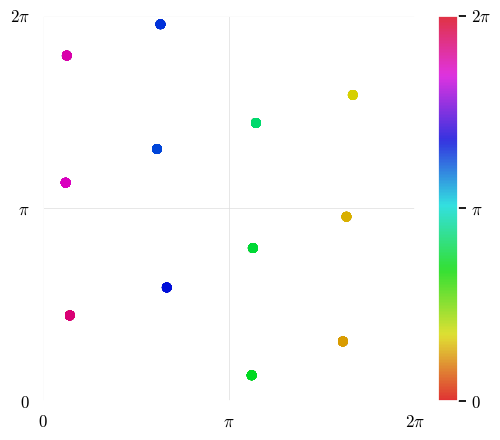

In [30]:
# model.update()
model.plot(fixLim=True)

In [11]:
draw_mp4(model, savePath=SAVE_PATH, mp4Path=MP4_PATH, fixLim=True)

100%|██████████| 1001/1001 [02:56<00:00,  5.67it/s]
